In [1]:
import os
from typing import List, Dict, Any, TypedDict, Annotated, Literal, Optional, Union
from langgraph.graph import StateGraph, END
from langgraph.checkpoint import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from playwright.sync_api import sync_playwright
import base64
from io import BytesIO
from PIL import Image
import requests
import time

# Definição do Estado
class AgentState(TypedDict):
    city: str
    state: str
    current_step: str
    search_queries: List[str]
    tried_domains: List[str]
    domains_to_check: List[str]
    current_domain: str
    found_transparency_domain: bool
    attempt_count: int
    screenshots: List[Dict[str, Any]]
    transparency_domain: str
    links_in_domain: List[Dict[str, Any]]
    salary_link: str
    error_message: Optional[str]
    final_result: Optional[str]

# Configuração do LLM
llm = ChatOpenAI(model="gpt-4-vision-preview", temperature=0)
text_llm = ChatOpenAI(model="gpt-4o", temperature=0)

# API da Tavily (simulada neste exemplo)
TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY", "seu_api_key_aqui")

# Ferramentas
@tool
def search_web(query: str) -> List[Dict[str, str]]:
    """Busca na web usando a Tavily API."""
    try:
        # Em um caso real, usaríamos a API da Tavily
        # Exemplo: tavily.search(query=query, api_key=TAVILY_API_KEY)
        # Aqui estamos simulando uma resposta
        print(f"Buscando: {query}")
        time.sleep(2)  # Simular delay da API
        
        # Simular resultados diferentes baseados na consulta
        domains = []
        if "portal transparência" in query.lower():
            domains = [
                {"url": f"https://{query.split()[0].lower()}.gov.br/transparencia", "content": "Portal da Transparência"},
                {"url": f"https://{query.split()[0].lower()}.transparente.com.br", "content": "Dados Abertos"},
                {"url": f"https://transparencia.{query.split()[0].lower()}.gov.br", "content": "Transparência Municipal"}
            ]
        return domains
    except Exception as e:
        return [{"url": "erro", "content": str(e)}]

@tool
def capture_screenshot(url: str) -> Dict[str, Any]:
    """Captura uma screenshot de uma página web usando Playwright."""
    try:
        with sync_playwright() as p:
            browser = p.chromium.launch()
            context = browser.new_context()
            page = context.new_page()
            page.goto(url, timeout=30000)
            time.sleep(2)  # Esperar página carregar
            screenshot = page.screenshot(type="jpeg", quality=80)
            
            # Converter screenshot para base64
            buffer = BytesIO(screenshot)
            image = Image.open(buffer)
            
            # Salvar HTML da página
            html_content = page.content()
            
            browser.close()
            
            # Converter imagem para base64
            buffered = BytesIO()
            image.save(buffered, format="JPEG")
            img_str = base64.b64encode(buffered.getvalue()).decode()
            
            return {
                "url": url, 
                "screenshot": img_str, 
                "html": html_content
            }
    except Exception as e:
        return {"url": url, "error": str(e)}

@tool
def extract_links_from_page(url: str) -> List[Dict[str, Any]]:
    """Extrai todos os links de uma página com seus elementos parent."""
    try:
        with sync_playwright() as p:
            browser = p.chromium.launch()
            context = browser.new_context()
            page = context.new_page()
            page.goto(url, timeout=30000)
            
            # Extrair links com JavaScript
            links_data = page.evaluate("""
                () => {
                    const links = Array.from(document.querySelectorAll('a'));
                    return links.map(link => {
                        const parent = link.parentElement;
                        return {
                            href: link.href,
                            text: link.textContent.trim(),
                            parentTag: parent ? parent.tagName : null,
                            parentClass: parent ? parent.className : null,
                            parentId: parent ? parent.id : null
                        };
                    });
                }
            """)
            
            browser.close()
            return links_data
    except Exception as e:
        return [{"error": str(e)}]

# Nós do grafo

def initialize_agent(state: AgentState) -> AgentState:
    """Inicializa o estado do agente."""
    city = state.get("city", "")
    state_abbr = state.get("state", "")
    
    if not city or not state_abbr:
        return {
            **state,
            "error_message": "Cidade e estado são obrigatórios.",
            "current_step": END
        }
    
    return {
        "city": city,
        "state": state_abbr,
        "current_step": "prepare_search_query",
        "search_queries": [],
        "tried_domains": [],
        "domains_to_check": [],
        "current_domain": "",
        "found_transparency_domain": False,
        "attempt_count": 0,
        "screenshots": [],
        "transparency_domain": "",
        "links_in_domain": [],
        "salary_link": "",
        "error_message": None,
        "final_result": None
    }

def prepare_search_query(state: AgentState) -> AgentState:
    """Prepara a query para buscar o portal de transparência."""
    city = state["city"]
    state_abbr = state["state"]
    tried_queries = state.get("search_queries", [])
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """Você é um especialista em buscas de portais de transparência governamentais.
        Crie uma query de busca eficiente para encontrar o portal de transparência da cidade 
        especificada, onde podem ser encontrados dados de salários de servidores públicos.
        
        As queries a seguir já foram tentadas e não tiveram sucesso:
        {tried_queries}
        
        Crie uma nova query diferente e mais específica."""),
        ("human", "Cidade: {city}, Estado: {state_abbr}")
    ])
    
    query_result = text_llm.invoke(
        prompt.format(
            city=city,
            state_abbr=state_abbr,
            tried_queries="\n".join(tried_queries) if tried_queries else "Nenhuma query tentada ainda"
        )
    )
    
    new_query = query_result.content.strip()
    tried_queries.append(new_query)
    
    return {
        **state,
        "search_queries": tried_queries,
        "current_step": "search_web",
        "attempt_count": state.get("attempt_count", 0) + 1
    }

def search_web_for_domains(state: AgentState) -> AgentState:
    """Executa a busca na web usando a query preparada."""
    search_queries = state.get("search_queries", [])
    
    if not search_queries:
        return {
            **state,
            "error_message": "Nenhuma query de busca disponível.",
            "current_step": END
        }
    
    latest_query = search_queries[-1]
    search_results = search_web(latest_query)
    
    if not search_results or (len(search_results) == 1 and "erro" in search_results[0].get("url", "")):
        return {
            **state,
            "error_message": f"Erro na busca web: {search_results[0].get('content', 'Erro desconhecido')}",
            "current_step": "check_max_attempts"
        }
    
    # Filtrar URLs que já foram tentadas
    new_domains = [
        result["url"] for result in search_results 
        if result["url"] not in state.get("tried_domains", [])
    ]
    
    return {
        **state,
        "domains_to_check": new_domains,
        "tried_domains": state.get("tried_domains", []) + new_domains,
        "current_step": "check_domains" if new_domains else "check_max_attempts"
    }

def check_domains(state: AgentState) -> AgentState:
    """Verifica cada domínio encontrado."""
    domains_to_check = state.get("domains_to_check", [])
    
    if not domains_to_check:
        return {
            **state,
            "current_step": "check_max_attempts"
        }
    
    current_domain = domains_to_check[0]
    remaining_domains = domains_to_check[1:]
    
    screenshot_data = capture_screenshot(current_domain)
    
    if "error" in screenshot_data:
        return {
            **state,
            "domains_to_check": remaining_domains,
            "current_step": "check_domains" if remaining_domains else "check_max_attempts"
        }
    
    screenshot_base64 = screenshot_data.get("screenshot", "")
    
    return {
        **state,
        "current_domain": current_domain,
        "domains_to_check": remaining_domains,
        "screenshots": state.get("screenshots", []) + [screenshot_data],
        "current_step": "analyze_screenshot"
    }

def analyze_screenshot(state: AgentState) -> AgentState:
    """Analisa a screenshot para determinar se é um portal de transparência."""
    current_domain = state.get("current_domain", "")
    screenshots = state.get("screenshots", [])
    
    if not screenshots:
        return {
            **state,
            "current_step": "check_domains" if state.get("domains_to_check") else "check_max_attempts"
        }
    
    latest_screenshot = next((s for s in screenshots if s.get("url") == current_domain), None)
    
    if not latest_screenshot or "error" in latest_screenshot:
        return {
            **state,
            "current_step": "check_domains" if state.get("domains_to_check") else "check_max_attempts"
        }
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """Analise a imagem da página web e determine se ela parece ser um portal de 
        transparência governamental onde podem ser acessados dados de salários de servidores públicos.
        
        Procure por indicações como:
        - Menções a "Portal da Transparência"
        - Links ou seções relacionadas a "Servidores", "Folha de Pagamento", "Salários"
        - Elementos de navegação para consultas de dados públicos
        
        Responda apenas SIM se você estiver razoavelmente confiante de que este é um portal de transparência 
        com dados de servidores, ou NÃO caso contrário. Em seguida, explique brevemente sua decisão."""),
        ("human", {"type": "image", "image_url": {"url": f"data:image/jpeg;base64,{latest_screenshot['screenshot']}"}}),
    ])
    
    analysis_result = llm.invoke(prompt)
    is_transparency_portal = analysis_result.content.strip().upper().startswith("SIM")
    
    if is_transparency_portal:
        return {
            **state,
            "found_transparency_domain": True,
            "transparency_domain": current_domain,
            "current_step": "extract_links"
        }
    else:
        return {
            **state,
            "current_step": "check_domains" if state.get("domains_to_check") else "check_max_attempts"
        }

def check_max_attempts(state: AgentState) -> AgentState:
    """Verifica se o número máximo de tentativas foi atingido."""
    if state.get("found_transparency_domain", False):
        return {
            **state,
            "current_step": "extract_links"
        }
    
    if state.get("attempt_count", 0) >= 5:
        return {
            **state,
            "error_message": "Não foi possível encontrar um portal de transparência após 5 tentativas.",
            "current_step": END
        }
    
    return {
        **state,
        "current_step": "prepare_search_query"
    }

def extract_links(state: AgentState) -> AgentState:
    """Extrai todos os links da página do portal de transparência."""
    transparency_domain = state.get("transparency_domain", "")
    
    if not transparency_domain:
        return {
            **state,
            "error_message": "Domínio do portal de transparência não encontrado.",
            "current_step": END
        }
    
    links_data = extract_links_from_page(transparency_domain)
    
    if not links_data or "error" in links_data[0]:
        return {
            **state,
            "error_message": f"Erro ao extrair links: {links_data[0].get('error', 'Erro desconhecido')}",
            "current_step": END
        }
    
    return {
        **state,
        "links_in_domain": links_data,
        "current_step": "find_salary_link"
    }

def find_salary_link(state: AgentState) -> AgentState:
    """Identifica qual link provavelmente leva aos dados de salários."""
    links = state.get("links_in_domain", [])
    
    if not links:
        return {
            **state,
            "error_message": "Nenhum link encontrado no portal de transparência.",
            "current_step": END
        }
    
    # Preparar uma representação textual dos links para análise
    links_text = []
    for i, link in enumerate(links[:30]):  # Limitar a 30 links para não sobrecarregar o prompt
        href = link.get("href", "")
        text = link.get("text", "")
        parent_info = f"Parent: {link.get('parentTag', '')} (class: {link.get('parentClass', '')}, id: {link.get('parentId', '')})"
        links_text.append(f"{i+1}. Texto: '{text}', URL: {href}, {parent_info}")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """Você é um especialista em portais de transparência governamentais.
        Analise a lista de links abaixo e identifique qual deles mais provavelmente leva 
        à página onde podem ser consultados dados de salários de servidores públicos.
        
        Procure por palavras-chave como:
        - "Folha de Pagamento"
        - "Remuneração"
        - "Salários"
        - "Servidores"
        - "Funcionários"
        - "Recursos Humanos"
        
        Responda apenas com o número do link escolhido e uma breve explicação."""),
        ("human", "Links encontrados no portal:\n\n{links}")
    ])
    
    analysis_result = text_llm.invoke(
        prompt.format(links="\n".join(links_text))
    )
    
    # Extrair o número do link da resposta
    result_text = analysis_result.content.strip()
    try:
        # Assume que o número do link está no início da resposta
        link_number = int(result_text.split('.')[0])
        if 1 <= link_number <= len(links):
            chosen_link = links[link_number - 1]
            return {
                **state,
                "salary_link": chosen_link.get("href", ""),
                "final_result": f"Portal de Transparência encontrado: {state.get('transparency_domain')}\n"
                              f"Link para dados de salários: {chosen_link.get('href', '')}\n"
                              f"Descrição: {chosen_link.get('text', '')}",
                "current_step": END
            }
    except:
        pass
    
    # Se não conseguiu identificar um número válido, usa o primeiro link com palavras-chave relevantes
    keywords = ["folha", "pagamento", "remuner", "salár", "servidor", "funcionár", "recursos humanos"]
    
    for link in links:
        text = link.get("text", "").lower()
        href = link.get("href", "").lower()
        
        if any(keyword in text or keyword in href for keyword in keywords):
            return {
                **state,
                "salary_link": link.get("href", ""),
                "final_result": f"Portal de Transparência encontrado: {state.get('transparency_domain')}\n"
                              f"Link para dados de salários: {link.get('href', '')}\n"
                              f"Descrição: {link.get('text', '')}",
                "current_step": END
            }
    
    return {
        **state,
        "error_message": "Não foi possível identificar um link específico para dados de salários.",
        "current_step": END
    }

# Definição do grafo
def build_transparency_agent():
    """Constrói e retorna o agente LangGraph."""
    workflow = StateGraph(AgentState)
    
    # Adicionar nós
    workflow.add_node("initialize", initialize_agent)
    workflow.add_node("prepare_search_query", prepare_search_query)
    workflow.add_node("search_web", search_web_for_domains)
    workflow.add_node("check_domains", check_domains)
    workflow.add_node("analyze_screenshot", analyze_screenshot)
    workflow.add_node("check_max_attempts", check_max_attempts)
    workflow.add_node("extract_links", extract_links)
    workflow.add_node("find_salary_link", find_salary_link)
    
    # Definir arestas
    workflow.set_entry_point("initialize")
    workflow.add_edge("initialize", "prepare_search_query")
    workflow.add_edge("prepare_search_query", "search_web")
    workflow.add_edge("search_web", "check_domains")
    workflow.add_edge("search_web", "check_max_attempts")
    workflow.add_edge("check_domains", "analyze_screenshot")
    workflow.add_edge("check_domains", "check_max_attempts")
    workflow.add_edge("analyze_screenshot", "check_domains")
    workflow.add_edge("analyze_screenshot", "extract_links")
    workflow.add_edge("check_max_attempts", "prepare_search_query")
    workflow.add_edge("check_max_attempts", "extract_links")
    workflow.add_edge("extract_links", "find_salary_link")
    
    # Compilar
    return workflow.compile()

# Exemplo de uso
def run_transparency_agent(city: str, state: str):
    """Executa o agente para uma cidade e estado específicos."""
    agent = build_transparency_agent()
    
    # Inicializar o estado
    initial_state = {"city": city, "state": state}
    
    # Executar o agente
    for state in agent.stream(initial_state):
        current_step = state.get("current_step", "")
        if current_step == END:
            if state.get("error_message"):
                print(f"Erro: {state['error_message']}")
            elif state.get("final_result"):
                print(f"Resultado final: {state['final_result']}")
            break
        else:
            print(f"Executando: {current_step}")
    
    return state


ImportError: cannot import name 'MemorySaver' from 'langgraph.checkpoint' (unknown location)

In [2]:
import os
from typing import List, Dict, Any, TypedDict, Annotated, Literal, Optional, Union
from langgraph.graph import StateGraph, END
# Removendo a importação problemática do MemorySaver
# from langgraph.checkpoint import MemorySaver 
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from playwright.sync_api import sync_playwright
import base64
from io import BytesIO
from PIL import Image
import requests
import time

# Definição do Estado
class AgentState(TypedDict):
    city: str
    state: str
    current_step: str
    search_queries: List[str]
    tried_domains: List[str]
    domains_to_check: List[str]
    current_domain: str
    found_transparency_domain: bool
    attempt_count: int
    screenshots: List[Dict[str, Any]]
    transparency_domain: str
    links_in_domain: List[Dict[str, Any]]
    salary_link: str
    error_message: Optional[str]
    final_result: Optional[str]

# Configuração do LLM
llm = ChatOpenAI(model="gpt-4-vision-preview", temperature=0)
text_llm = ChatOpenAI(model="gpt-4o", temperature=0)

# API da Tavily (simulada neste exemplo)
TAVILY_API_KEY = os.environ.get("TAVILY_API_KEY", "seu_api_key_aqui")

# Ferramentas
@tool
def search_web(query: str) -> List[Dict[str, str]]:
    """Busca na web usando a Tavily API."""
    try:
        # Em um caso real, usaríamos a API da Tavily
        # Exemplo: tavily.search(query=query, api_key=TAVILY_API_KEY)
        # Aqui estamos simulando uma resposta
        print(f"Buscando: {query}")
        time.sleep(2)  # Simular delay da API
        
        # Simular resultados diferentes baseados na consulta
        domains = []
        if "portal transparência" in query.lower():
            domains = [
                {"url": f"https://{query.split()[0].lower()}.gov.br/transparencia", "content": "Portal da Transparência"},
                {"url": f"https://{query.split()[0].lower()}.transparente.com.br", "content": "Dados Abertos"},
                {"url": f"https://transparencia.{query.split()[0].lower()}.gov.br", "content": "Transparência Municipal"}
            ]
        return domains
    except Exception as e:
        return [{"url": "erro", "content": str(e)}]

@tool
def capture_screenshot(url: str) -> Dict[str, Any]:
    """Captura uma screenshot de uma página web usando Playwright."""
    try:
        with sync_playwright() as p:
            browser = p.chromium.launch()
            context = browser.new_context()
            page = context.new_page()
            page.goto(url, timeout=30000)
            time.sleep(2)  # Esperar página carregar
            screenshot = page.screenshot(type="jpeg", quality=80)
            
            # Converter screenshot para base64
            buffer = BytesIO(screenshot)
            image = Image.open(buffer)
            
            # Salvar HTML da página
            html_content = page.content()
            
            browser.close()
            
            # Converter imagem para base64
            buffered = BytesIO()
            image.save(buffered, format="JPEG")
            img_str = base64.b64encode(buffered.getvalue()).decode()
            
            return {
                "url": url, 
                "screenshot": img_str, 
                "html": html_content
            }
    except Exception as e:
        return {"url": url, "error": str(e)}

@tool
def extract_links_from_page(url: str) -> List[Dict[str, Any]]:
    """Extrai todos os links de uma página com seus elementos parent."""
    try:
        with sync_playwright() as p:
            browser = p.chromium.launch()
            context = browser.new_context()
            page = context.new_page()
            page.goto(url, timeout=30000)
            
            # Extrair links com JavaScript
            links_data = page.evaluate("""
                () => {
                    const links = Array.from(document.querySelectorAll('a'));
                    return links.map(link => {
                        const parent = link.parentElement;
                        return {
                            href: link.href,
                            text: link.textContent.trim(),
                            parentTag: parent ? parent.tagName : null,
                            parentClass: parent ? parent.className : null,
                            parentId: parent ? parent.id : null
                        };
                    });
                }
            """)
            
            browser.close()
            return links_data
    except Exception as e:
        return [{"error": str(e)}]

# Nós do grafo

def initialize_agent(state: AgentState) -> AgentState:
    """Inicializa o estado do agente."""
    city = state.get("city", "")
    state_abbr = state.get("state", "")
    
    if not city or not state_abbr:
        return {
            **state,
            "error_message": "Cidade e estado são obrigatórios.",
            "current_step": END
        }
    
    return {
        "city": city,
        "state": state_abbr,
        "current_step": "prepare_search_query",
        "search_queries": [],
        "tried_domains": [],
        "domains_to_check": [],
        "current_domain": "",
        "found_transparency_domain": False,
        "attempt_count": 0,
        "screenshots": [],
        "transparency_domain": "",
        "links_in_domain": [],
        "salary_link": "",
        "error_message": None,
        "final_result": None
    }

def prepare_search_query(state: AgentState) -> AgentState:
    """Prepara a query para buscar o portal de transparência."""
    city = state["city"]
    state_abbr = state["state"]
    tried_queries = state.get("search_queries", [])
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """Você é um especialista em buscas de portais de transparência governamentais.
        Crie uma query de busca eficiente para encontrar o portal de transparência da cidade 
        especificada, onde podem ser encontrados dados de salários de servidores públicos.
        
        As queries a seguir já foram tentadas e não tiveram sucesso:
        {tried_queries}
        
        Crie uma nova query diferente e mais específica."""),
        ("human", "Cidade: {city}, Estado: {state_abbr}")
    ])

In [3]:

# # Exemplo de chamada
# if __name__ == "__main__":
#     city = input("Digite o nome da cidade: ")
#     state = input("Digite a sigla do estado: ")
#     result = run_transparency_agent(city, state)
#     print("\nProcesso concluído!")

# Teste

In [16]:
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph, END
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from playwright.sync_api import sync_playwright

# Constants\ n

MAX_ATTEMPTS = 5

# --- State Definition ---
class AgentState(TypedDict):
    city: str
    state: str
    queries_tested: List[str]
    candidates: List[str]
    attempt: int
    domain: Optional[str]

# # --- Tool Setup ---
# tools = [TavilySearchResults(max_results=5)]
# tool_executor = ToolExecutor(tools)

# Multimodal LLM (ChatOpenAI with vision capabilities)
model = ChatOpenAI(temperature=0, streaming=True)

In [6]:
from typing import List, Optional
from pydantic import BaseModel
from langgraph.graph import StateGraph, END
from langchain.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from playwright.sync_api import sync_playwright

# Configurações
MAX_ATTEMPTS = 5

# --- Estado do Agente ---
class AgentState(BaseModel):
    city: Optional[str] = None
    state: Optional[str] = None
    queries_tested: List[str] = []
    candidates: List[str] = []
    attempt: int = 0
    domain: Optional[str] = None
    links_info: Optional[List[dict]] = None
    selected_link: Optional[str] = None

# LLM
llm = ChatOpenAI(temperature=0)

# --- Nós ---

def init_input(_: AgentState) -> AgentState:
    city = input("Cidade: ")
    uf = input("Estado: ")
    return AgentState(city=city, state=uf)


def prepare_query(state: AgentState) -> dict:
    q = f"portal transparência {state.city} {state.state} salário servidores"
    state.attempt += 1
    state.queries_tested.append(q)
    return {"query": q}


def search_domains(state: AgentState, query: str) -> dict:
    tool = TavilySearchResults(max_results=5)
    results = tool.run(query=query)
    domains = [r["link"] for r in results]
    state.candidates = domains
    return {"candidates": domains}


def evaluate_results(state: AgentState, candidates: List[str]) -> dict:
    with sync_playwright() as pw:
        browser = pw.chromium.launch()
        page = browser.new_page()
        for dom in candidates:
            page.goto(dom)
            shot = page.screenshot()
            resp = llm.invoke({"image": shot, "prompt": "Esta página contém seção de salário de servidores públicos? Responda com sim ou não."})
            if "sim" in resp.content.lower():
                state.domain = dom
                browser.close()
                return {"found": True}
        browser.close()
    return {"found": False}


def list_links(state: AgentState) -> dict:
    with sync_playwright() as pw:
        browser = pw.chromium.launch()
        page = browser.new_page()
        page.goto(state.domain)
        els = page.query_selector_all("a")
        info = []
        for el in els:
            href = el.get_attribute("href")
            parent = el.evaluate("e => e.parentElement.outerHTML")
            info.append({"href": href, "parent_html": parent})
        browser.close()
    state.links_info = info
    return {"links_info": info}


def select_link(state: AgentState, links_info: List[dict]) -> dict:
    prompt = (
        "Dada esta lista de links e seus elementos pais, qual link leva aos dados de salário dos servidores públicos?\n"
        f"Links: {links_info}"
    )
    resp = llm.invoke({"prompt": prompt})
    state.selected_link = resp.content.strip()
    return {"selected_link": state.selected_link}




In [12]:
# --- Montagem do Grafo ---
workflow = StateGraph(AgentState)


workflow.add_node("init", init_input)
workflow.add_node("prepare_query", prepare_query)
workflow.add_node("search_domains", search_domains)
workflow.add_node("evaluate", evaluate_results)
workflow.add_node("list_links", list_links)
workflow.add_node("select_link", select_link)
workflow.set_entry_point("init")

# Conexões
workflow.add_edge("init", "prepare_query")
workflow.add_edge("prepare_query", "search_domains")
workflow.add_edge("search_domains", "evaluate")
workflow.add_conditional_edges(
    "evaluate",
    lambda s: "list_links" if s.domain else ("prepare_query" if s.attempt < MAX_ATTEMPTS else "fail"),
    {"list_links": "list_links", "prepare_query": "prepare_query", "fail": END},
)
workflow.add_edge("list_links", "select_link")


graph = workflow.compile()

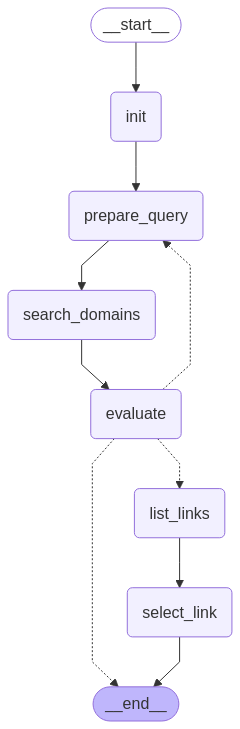

In [13]:
graph

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

AttributeError: 'StateGraph' object has no attribute 'get_graph'

In [ ]:
    state = workflow.invoke({})
    print("Link selecionado:", state.selected_link)
